An example notebook demonstrating the workflow of:
1. **Instantiating a Bayesian Neural Network using quantbayes**
2. **Training and evaluating using Pac bayes Bound**

## Full bayesian Network

In [1]:
import jax 
import jax.random as jr
import jax.numpy as jnp
import numpyro 
import numpyro.distributions as dist

from quantbayes import bnn 

class BayesNet(bnn.Module):
  def __init__(self):
    super().__init__(method="nuts", task_type="regression")
  
  def __call__(self, X, y=None):
    N, in_features = X.shape
    X = bnn.FFTLinear(in_features=in_features,      # Notice the use of Circulant FFT matrix-vector multiplication (custom layer)
                   name="FFT Layer 1")(X)
    X = jax.nn.tanh(X)
    X = bnn.Linear(in_features=in_features, 
                   out_features=1,
                   name="Layer 2")(X)
    logits = X.squeeze()
    numpyro.deterministic("logits", logits)
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    with numpyro.plate("data", N):
      numpyro.sample("likelihood", dist.Normal(logits, sigma), obs=y)

/home/jmar/quantbayes/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## We try our experiments on some simple data

sample: 100%|██████████| 1500/1500 [00:06<00:00, 227.15it/s, 63 steps of size 3.81e-02. acc. prob=0.93] 


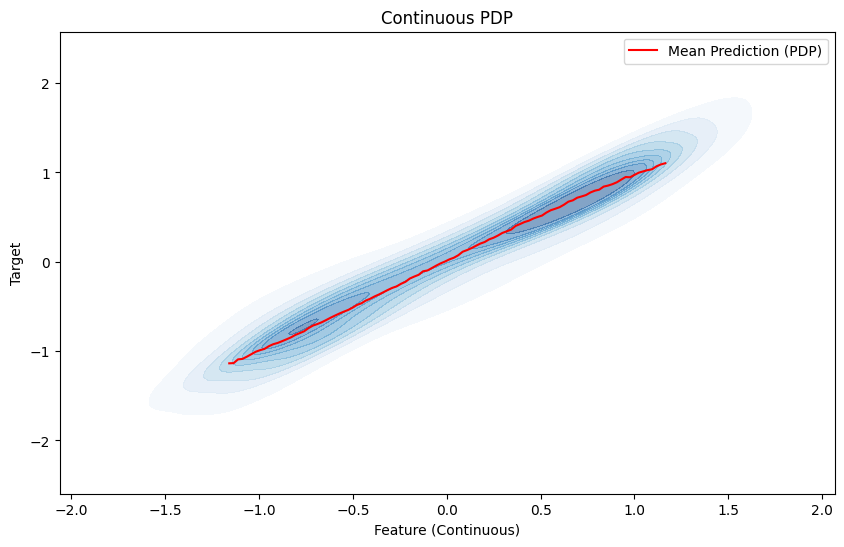

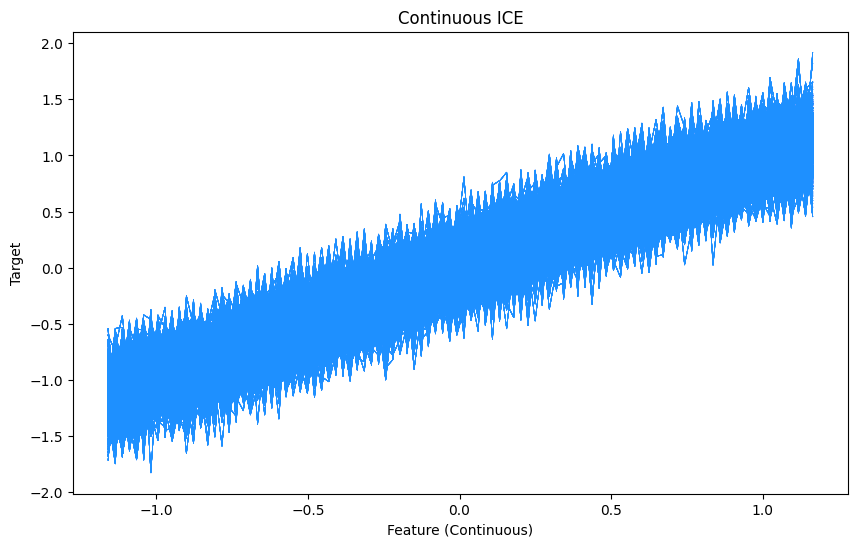

Empirical risk: 0.048
Confidence term: 0.106
KL-Divergence: 14.826
Pac-Bayes Bound: 0.153


Array(0.1530943, dtype=float32)

In [2]:
from quantbayes import fake_data 
from quantbayes.bnn.utils import BayesianAnalysis
from sklearn.model_selection import train_test_split

df = fake_data.generate_regression_data() 
X, y = df.drop("target", axis=1), df["target"]
X, y = jnp.array(X), jnp.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

########################################################################
# 2. Model train and predict
########################################################################
train_key, val_key = jr.split(jr.key(123), 2)

model = BayesNet()
model.compile(num_warmup=500, num_samples=1000)
model.fit(X_train, y_train, train_key)
model.visualize(X_test, y_test, posterior="likelihood", feature_index=0)
posterior_preds = model.predict(X_test, val_key, posterior="logits")        # We could also sample from "likelihood"/mean
posterior_samples = model.get_samples

########################################################################
# 3. Model evaluation
########################################################################

bound = BayesianAnalysis(num_samples=len(X_train), 
                         delta=0.05,
                         task_type="regression",
                         inference_type="mcmc",
                         posterior_samples=posterior_samples
                         )
bound.compute_pac_bayesian_bound(predictions=posterior_preds,
                                 y_true=y_test,
                                 prior_mean= 0.0,
                                 prior_std=1.0
                                 )

## Now we try the other approach
We instantiate a deterministic network and then "bayesianize" the parameters into prior distributions

sample: 100%|██████████| 1500/1500 [00:05<00:00, 279.09it/s, 31 steps of size 4.05e-02. acc. prob=0.95] 


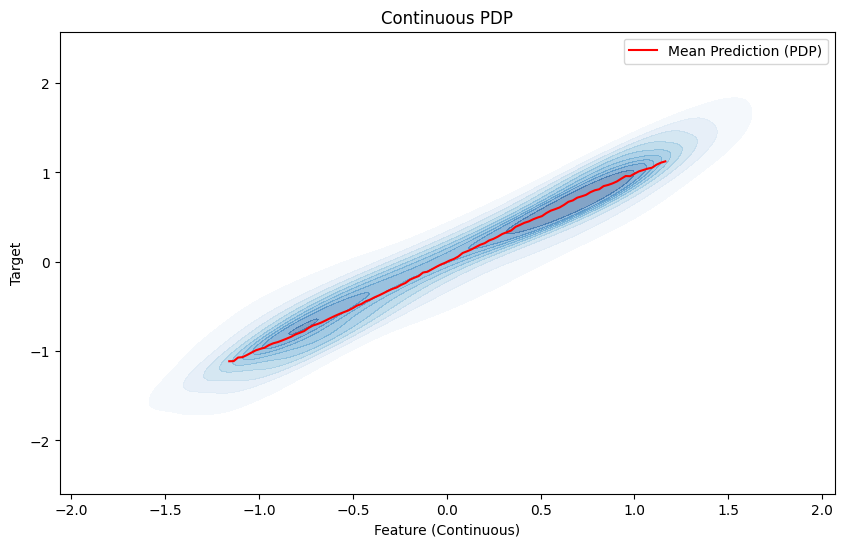

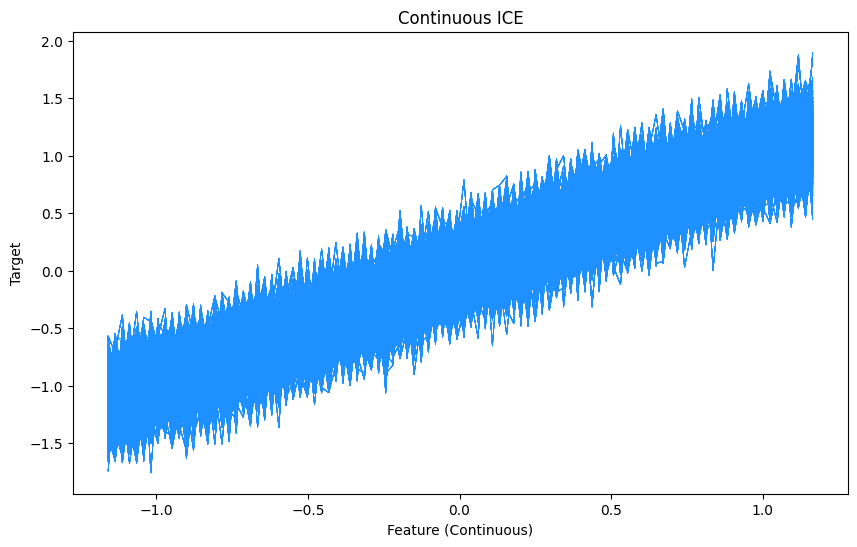

Empirical risk: 0.047
Confidence term: 0.106
KL-Divergence: 14.826
Pac-Bayes Bound: 0.153
Empirical risk: 0.047
Confidence term: 0.106
KL-Divergence: 14.826
Pac-Bayes Bound: 0.153


Array(0.15274525, dtype=float32)

In [3]:
from quantbayes.stochax.utils import bayesianize, prior_fn, CirculantLinear
import equinox as eqx

class MyDeterministicNet(eqx.Module):
  layer1: eqx.Module 
  layer2: eqx.Module

  def __init__(self, in_features, *, key):
    k1, k2 = jr.split(key, 2)
    self.layer1 = CirculantLinear(in_features=in_features, key=k1)        # Notice the use of Circulant FFT matrix-vector multiplication (custom layer)
    self.layer2 = eqx.nn.Linear(in_features=in_features, out_features=1, key=k2)
  
  def __call__(self, x):
    x = self.layer1(x)
    x = jax.nn.tanh(x)
    return self.layer2(x)

class MyBayesianNet(bnn.Module):
  def __init__(self):
    super().__init__(method="nuts", task_type="regression") 
  
  def __call__(self, X, y=None):
    N, in_features = X.shape 
    key = jr.key(23)
    deterministic = MyDeterministicNet(in_features, key=key)
    bayesian_net = bayesianize(deterministic, prior_fn)
    pred = jax.vmap(bayesian_net)(X)
    logits = pred.squeeze()
    numpyro.deterministic("logits", logits)
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    with numpyro.plate("data", N):
      numpyro.sample("likelihood", dist.Normal(logits, sigma), obs=y) 

model = MyBayesianNet()         # New approach
model.compile(num_warmup=500, num_samples=1000)
model.fit(X_train, y_train, train_key)
model.visualize(X_test, y_test, posterior="likelihood", feature_index=0)
posterior_preds = model.predict(X_test, val_key, posterior="logits")        # We could also sample from "likelihood"/mean
posterior_samples = model.get_samples
bound.compute_pac_bayesian_bound(predictions=posterior_preds,
                                 y_true=y_test,
                                 prior_mean= 0.0,
                                 prior_std=1.0
                                 )
bound.compute_pac_bayesian_bound(predictions=posterior_preds,
                                 y_true=y_test,
                                 prior_mean= 0.0,
                                 prior_std=1.0
                                 )


As we can see, we reproduced the results using the two approaches.

This technique enables us to integrate deterministic neural networks with Bayesian inference.
